In [1]:
from pymongo import MongoClient
import pandas as pd
import time
import re
import requests
import json
import pandas as pd
from getpass import getpass
import time
from dotenv import load_dotenv


In [2]:
import matplotlib.pyplot as plt

In [3]:
def mongo_access(name, collection):
    client = MongoClient("localhost:27017")
    db = client[name]
    c = db.get_collection(collection)
    return c

In [4]:
c = mongo_access("Ironhack", "companies")

In [5]:
def mongo_design_query(c):
    condition1= {"total_money_raised": {"$regex": "[MB]$"}}
    condition2={"tag_list": {"$regex": "design"}}
    condition3={"category_code": "design"}

    query = {"$and": [condition1 ,{"$or": [condition2, condition3]}]}
    projection={"name":1, "_id":0, "total_money_raised":1, 
                "tag_list":1, "description":1, "offices":1, "category_code":1 }

    design_companies=list(c.find(query, projection).sort('offices.country_code'))
    df=pd.DataFrame(design_companies)
    return df

In [6]:
df=mongo_design_query(c)
df.sample()

,name,category_code,tag_list,description,total_money_raised,offices
6,EasyLink,network_hosting,"easylink, india, web-design, web-application-d...",None,$5.4M,"[{'description': None, 'address1': 'C-Block, 1..."


In [8]:
def cleaning_df(df):

    df['city'] = ''
    for index, row in df.iterrows():
        offices = row['offices']  
        for i in range(len(offices)):  
            city = offices[i].get('city', '')  
            df.at[index, 'city'] += (city + ' ,')
            
    df['state_code'] = ''
    for index, row in df.iterrows():
        offices = row['offices']  
        for i in range(len(offices)):  
            x = offices[i].get('state_code', '')  
            df.at[index, 'state_code'] += (str(x) + ' ,')
          
    cities_list=list(df['city'])  
    cities = [city.strip() for cities in cities_list for city in cities.split(',')]
    cities = [city for city in cities if city != '']
    
    df.to_csv("../dataframes/design_companies.csv", index=False)
    
    return df, cities

In [9]:
df,cities=cleaning_df(df)
df.sample()

,name,category_code,tag_list,description,total_money_raised,offices,city,state_code
4,Gnodal,network_hosting,"design, infrastructure, systems",High Performance Datacenter,$2.19M,"[{'description': 'Registered Office', 'address...","Bristol ,Palo Alto ,","None ,CA ,"


In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def designers_cities_plot(cities,df):

    unique_cities, city_counts = np.unique(cities, return_counts=True)

    #Sort the cities and counts in descending order
    sorted_indices = np.argsort(city_counts)[::-1]
    unique_cities = unique_cities[sorted_indices]
    city_counts = city_counts[sorted_indices]

    #Create a bar plot
    plt.bar(unique_cities, city_counts, color='skyblue')

    #Set the labels and title
    plt.xlabel('City')
    plt.ylabel('Count')
    plt.title('Companies with Designers per City')

    #Rotate the x-axis labels for better visibility
    plt.xticks(rotation=90)

    #Adjust the layout
    plt.tight_layout()

    #Display the plot
    plt.show()

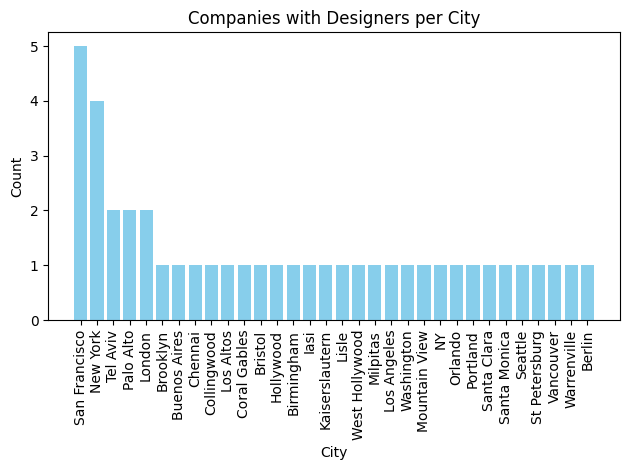

In [12]:
designers_cities_plot(cities,df)

In [13]:
def mongo_games_query(c):

    condition1={"total_money_raised":  {"$regex": "M$"}}
    condition2={"description": {"$regex": "gam"}}
    condition3={"category_code": "games-video"}

    query = {"$and": [condition1,{"$or": [condition2, condition3]}]}
    projection={"name":1, "_id":0, "total_money_raised":1, 
                "tag_list":1, "description":1, "offices":1, "category_code":1 }

    gaming_money_raised=list(c.find(query, projection))
    
    df=pd.DataFrame(gaming_money_raised)
    
    return df

In [14]:
df2=mongo_games_query(c)
df2.sample()

,name,category_code,tag_list,description,total_money_raised,offices
36,GotGame,games_video,"games, video-games, videos, gaming-videos, new...",Applications for in-game social media,$1M,"[{'description': 'GotGame HQ', 'address1': '1 ..."


In [15]:
def cleaning_df2(df2):
    df2['currency'] = ''
    # Iterate over the rows and update the 'currency' column based on the symbols
    for index, row in df2.iterrows():
        if '€' in row['total_money_raised']:
            df2.at[index, 'currency'] = '€'
        elif '$' in row['total_money_raised']:
            df2.at[index, 'currency'] = '$'
        elif '¥' in row['total_money_raised']:
            df2.at[index, 'currency'] = '¥'
    
    # Remove non-numeric elements from the 'total_money_raised' column
    df2['total_money_raised'] = df2['total_money_raised'].str.replace(r'\D', '', regex=True)
    df2['total_money_raised'] = df2['total_money_raised'].astype(float)
    
    for index, row in df2.iterrows():
        if row["currency"] == "€":
            df2.at[index, 'total_money_raised'] *= 1.2
        elif row["currency"] == "¥":
            df2.at[index, 'total_money_raised'] *= 0.0074
    
    df2['total_money_raised'] =df2['total_money_raised'].round(1)
    df2 = df2.sort_values('total_money_raised',ascending=False)
    df2 = df2.reset_index(drop=True)
    
    df2['city'] = ''
    for index, row in df2.iterrows():
        offices = row['offices']  
        for i in range(len(offices)):  
            city = offices[i].get('city', '')  
            df2.at[index, 'city'] += (city + ' ,')
            
    df2['country_code'] = ''
    for index, row in df2.iterrows():
        offices = row['offices']  
        for i in range(len(offices)):  
            code = offices[i].get('country_code', '')  
            df2.at[index, 'country_code'] += (code + ' ')
    
    df2.to_csv("../dataframes/game_companies.csv", index=False)
    
    return df2

In [16]:
df2=cleaning_df2(df2)
df2.head()

,name,category_code,tag_list,description,total_money_raised,offices,currency,city,country_code
0,Zynga,games_video,"facebookapplications, games, socialnetworking,...",Network of gaming applications,860.0,"[{'description': 'SF HQ', 'address1': '365 Ver...",$,"San Francisco , ,Baltimore ,Los Angeles ,",USA IND USA USA
1,Realtime Worlds,games_video,games,"Entertainment software, Videogames",828.0,"[{'description': None, 'address1': '', 'addres...",$,"Dundee ,Boulder ,",GBR USA
2,Crispy Gamer,games_video,"videogaming, community, editorial, the-game-tr...",videogame review community,825.0,"[{'description': '', 'address1': '35 West 36th...",$,"New York ,",USA
3,Aurora Feint,games_video,,games and platforms for iPhone,766.0,"[{'description': 'HQ', 'address1': '330 Primro...",$,"Burlingame ,",USA
4,Turbine,games_video,"game, online-games, social-gaming, role-playin...",creates and operates online games,766.0,"[{'description': None, 'address1': '60 Glacier...",$,"Westwood ,Redwood City ,",USA USA


In [17]:
def game_cities_df(df2):
    
    cities_list = df2[df2['total_money_raised'] >= 200]['city'].values
    
    cities = [city.strip() for cities in cities_list for city in cities.split(',')]
    cities = [city for city in cities if city != '']
    

    # Create a DataFrame from the list of cities
    df3 = pd.DataFrame({'city': cities})

    # Get the count of occurrences for each city
    city_counts = df3['city'].value_counts()

    # Create a new DataFrame with the top occurring values
    game_top_cities = pd.DataFrame({'city': city_counts.index, 'count': city_counts.values})

    # DataFrame with the top occurring values
    game_top_cities.to_csv("../dataframes/game_200M_cities.csv", index=False)
    
    return game_top_cities

In [18]:
game_top_cities=game_cities_df(df2)
game_top_cities

,city,count
0,San Francisco,7
1,Madrid,3
2,New York,3
3,London,2
4,Berlin,1
5,Bucuresti,1
6,Dublin,1
7,Seattle,1
8,Boston,1
9,Santa Clara,1


In [19]:
import matplotlib.pyplot as plt


In [20]:
def game_cities_plot(game_top_cities):

    # Group cities with count 1 as 'Others'
    game_top_cities.loc[game_top_cities['count'] == 1, 'city'] = 'Others'

    # Calculate the sum of counts for each city
    city_counts = game_top_cities.groupby('city')['count'].sum()

    # Define colors for the pie slices
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0f0', '#ffb3b3', '#ccff99', '#dab3ff']

    # Create a pie plot
    plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)

    # Add a shadow to the pie plot
    plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))

    # Set the aspect ratio to be equal
    plt.axis('equal')

    # Set the title and adjust the layout
    plt.title('Top count of Game Companies Offices by city and Raised Amount')
    plt.tight_layout()

    # Display and save the plot
    plt.show()

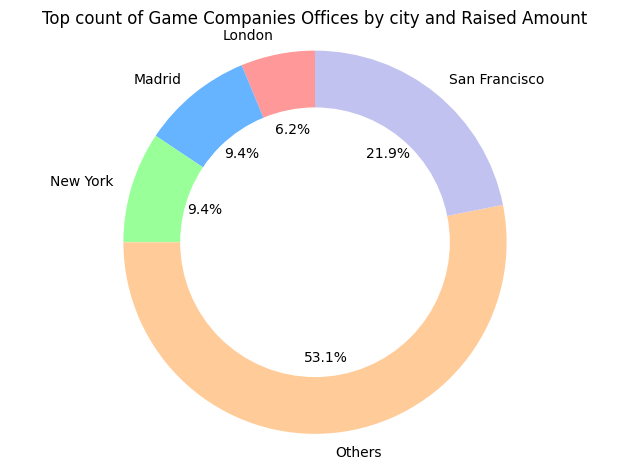

In [21]:
game_cities_plot(game_top_cities)

In [22]:
#top_cities_design.to_csv("../dataframes/200M_game_cities_designers.csv", index=False)

In [23]:
def design_gaming_df(c):

    condition={"total_money_raised":  {"$regex": "M$"}}
    condition1={"total_money_raised":  {"$regex": "[MB]$"}}
    condition2={"tag_list": {"$regex": "design"}}
    condition3={"category_code": "design"}
    condition4={"offices.city": "New York"}
    condition5={"offices.city": "London"}
    condition6={"offices.city": "San Francisco"}

    query = {"$and": [{"$or": [condition, condition1]}, {"$or": [condition4,condition5,condition6]}, {"$or": [condition2, condition3]}]}
    projection={"name":1, "_id":0, "total_money_raised":1, 
                "tag_list":1, "description":1, "offices":1, "category_code":1 }

    design_gaming_money =list(c.find(query, projection))
    
    df3=pd.DataFrame(design_gaming_money)
    
    # Define the desired cities
    desired_cities = ["New York", "London", "San Francisco"]

    # Apply the filter on the "offices" column
    df3['offices'] = df3['offices'].apply(lambda x: [office for office in x if any(city in office.get('city', '') for city in desired_cities)])

    
    return df3

In [24]:
df3=design_gaming_df(c)
df3

,name,category_code,tag_list,description,total_money_raised,offices
0,Digg,news,"community, social, news, bookmark, digg, techn...",user driven social content website,$45M,"[{'description': None, 'address1': '135 Missis..."
1,Wix,web,"website, widget, design, flash, internet",Drag-and-Drop Web Publishing Platform,$58.5M,"[{'description': '', 'address1': '', 'address2..."
2,Gilt Groupe,fashion,"clothing, fashion, designer, apparel, luxury, ...",Designer Sample Sales Online,$236M,"[{'description': 'New York Office', 'address1'..."
3,99designs,design,"graphic-design, crowdsourcing, online-marketpl...",Online graphic design marketplace,$35M,"[{'description': 'United States (HQ)', 'addres..."
4,Minted,ecommerce,"crowd-sourcing, design, art, stationery, ecomm...",marketplace for design and art,$52.7M,"[{'description': '', 'address1': '747 Front St..."
5,Squarespace,web,"software, web-design, website-creation-platfor...",Fully-hosted website creator,$38.5M,"[{'description': 'Squarespace', 'address1': '4..."
6,Banyan Branch,news,"social-media, consulting, twitter, facebook, m...",Social media marketing agency,$1.7M,"[{'description': 'New York office', 'address1'..."
7,Netbiscuits,mobile,"mobile-web, cloud-platform, adaptive-web-techn...",Mobile Web Development Platform,$27M,"[{'description': 'Netbiscuits UK', 'address1':..."
8,Moonfruit,design,,,$2.25M,"[{'description': 'UK Office', 'address1': '', ..."


In [25]:
def cleaning_df3(df):
    # Crear una lista para almacenar las filas adicionales
    new_rows = []

    # Recorrer el DataFrame
    for index, row in df.iterrows():
        offices = row['offices']
        if len(offices) > 1:
            # Si la lista tiene más de un diccionario, crear una nueva fila por cada diccionario
            for i in offices:
                new_row = row.copy()
                new_row['offices'] = [i]
                new_rows.append(new_row)
        else:
            # Si la lista tiene solo un diccionario, mantener la fila original
            new_rows.append(row)


    # Crear un nuevo DataFrame con las filas adicionales
    df= pd.DataFrame(new_rows)
    df.reset_index(drop=True, inplace=True)

    
    data_type=['longitude', 'latitude', 'city', 'address1', 'address2', 'state_code', 'country_code']
    
    for i in data_type:
        df[i] = ''
        for index, row in df.iterrows():
            offices = row['offices']
            for office in offices:
                x = office.get(i, '')
                df.at[index, i] += str(x)

    df = df.drop("offices", axis=1)
    
    netbiscuits_lon= '-73.93230'
    netbiscuits_lat= '40.69517'
    
    # Update the value of the "longitude" and "latitude" column
    df.loc[(df['name'] == 'Netbiscuits') & (df['state_code'] == 'NY'), 'longitude'] = netbiscuits_lon
    df.loc[(df['name'] == 'Netbiscuits') & (df['state_code'] == 'NY'), 'latitude'] = netbiscuits_lat
    
    offices_dict= {'Wix': ['-122.40507','37.75672'],
                  'Squarespace': ['-74.00087','40.72081'],
                  'Banyan Branch':['-73.93230','40.69517'],
                  'Moonfruit':['-0.11016','51.51913'],
                      }     
        
    for key, value in offices_dict.items():   
        df.loc[df['name'] == key, 'longitude'] = value[0]
        df.loc[df['name'] == key,'latitude'] = value[1]
        # Update the value of the "longitude" column

    df["data"] = "Design company"
    df.to_csv("../dataframes/design_coordinates.csv", index=False)
    
    return df

    

In [26]:
df3=cleaning_df3(df3)

In [27]:
df3

,name,category_code,tag_list,description,total_money_raised,longitude,latitude,city,address1,address2,state_code,country_code,data
0,Digg,news,"community, social, news, bookmark, digg, techn...",user driven social content website,$45M,-122.394523,37.764726,San Francisco,135 Mississippi St,,CA,USA,Design company
1,Wix,web,"website, widget, design, flash, internet",Drag-and-Drop Web Publishing Platform,$58.5M,-122.40507,37.75672,San Francisco,,,CA,USA,Design company
2,Gilt Groupe,fashion,"clothing, fashion, designer, apparel, luxury, ...",Designer Sample Sales Online,$236M,-73.9800645,40.74727,New York,2 Park Ave Fl 4,,NY,USA,Design company
3,99designs,design,"graphic-design, crowdsourcing, online-marketpl...",Online graphic design marketplace,$35M,-122.4005983,37.7955307,San Francisco,447 Battery St.,3rd Floor,CA,USA,Design company
4,Minted,ecommerce,"crowd-sourcing, design, art, stationery, ecomm...",marketplace for design and art,$52.7M,-122.403175,37.797435,San Francisco,747 Front Street,2nd Floor,CA,USA,Design company
5,Squarespace,web,"software, web-design, website-creation-platfor...",Fully-hosted website creator,$38.5M,-74.00087,40.72081,New York,459 Broadway,5th Floor,NY,USA,Design company
6,Banyan Branch,news,"social-media, consulting, twitter, facebook, m...",Social media marketing agency,$1.7M,-73.93230,40.69517,New York,"455 Broadway, 3rd Floor",,NY,USA,Design company
7,Netbiscuits,mobile,"mobile-web, cloud-platform, adaptive-web-techn...",Mobile Web Development Platform,$27M,-0.1547377,51.513248,London,25 North Row,,None,GBR,Design company
8,Netbiscuits,mobile,"mobile-web, cloud-platform, adaptive-web-techn...",Mobile Web Development Platform,$27M,-73.93230,40.69517,New York,7th Floor,275 Seventh Ave,NY,USA,Design company
9,Netbiscuits,mobile,"mobile-web, cloud-platform, adaptive-web-techn...",Mobile Web Development Platform,$27M,-122.4264417,37.7550372,San Francisco,Suite 2200,425 Market Street,CA,USA,Design company


In [28]:
import requests
import json
import pandas as pd
from getpass import getpass
import time
from dotenv import load_dotenv


In [29]:
def cities_dfs(df3):
    df_sf= df3[df3['city'] == 'San Francisco'][['name', 'latitude', 'longitude', 'data']].copy()
    df_sf.to_csv("../dataframes/df_sanfrancisco.csv", index=False)
    
    df_nyc= df3[df3['city'] == 'New York'][['name', 'latitude', 'longitude','data']].copy()
    df_nyc.to_csv("../dataframes/df_newyork.csv", index=False)
    
    df_lon= df3[df3['city'] == 'London'][['name', 'latitude', 'longitude','data']].copy()
    df_lon.to_csv("../dataframes/df_london.csv", index=False)
    
    return df_sf, df_nyc, df_lon

In [30]:
df_sf, df_nyc, df_lon = cities_dfs(df3)

In [31]:
df_sf

,name,latitude,longitude,data
0,Digg,37.764726,-122.394523,Design company
1,Wix,37.75672,-122.40507,Design company
3,99designs,37.7955307,-122.4005983,Design company
4,Minted,37.797435,-122.403175,Design company
9,Netbiscuits,37.7550372,-122.4264417,Design company


In [32]:
df_nyc

,name,latitude,longitude,data
2,Gilt Groupe,40.74727,-73.9800645,Design company
5,Squarespace,40.72081,-74.00087,Design company
6,Banyan Branch,40.69517,-73.93230,Design company
8,Netbiscuits,40.69517,-73.93230,Design company


In [33]:
df_lon

,name,latitude,longitude,data
7,Netbiscuits,51.513248,-0.1547377,Design company
10,Moonfruit,51.51913,-0.11016,Design company
